<a href="https://colab.research.google.com/github/OswaldGutierrez/Modelos-IA/blob/main/RedNeuronalMulticapa_NATICUSdroid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RED NEURONAL MULTICAPA

<font size="3">**1. IMPORTACIÓN DE LIBRERÍAS NECESARIAS**</font>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import time

<font size="3">**2. CARGA Y CARACTERÍSTICAS DEL DATASET**</font>

In [2]:
!wget https://raw.githubusercontent.com/xiomara-udea/NATICUSdroid/main/data.csv
import pandas as pd
df = pd.read_csv("data.csv")

# Separar características (X) y etiqueta (y)
X = df.drop('Result', axis=1)
y = df['Result']

print(f"  - Características: {X.shape[1]}")
print(f"  - Muestras: {len(y)}")

--2025-11-24 12:53:54--  https://raw.githubusercontent.com/xiomara-udea/NATICUSdroid/main/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5136567 (4.9M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   4.90M  --.-KB/s    in 0.06s   

2025-11-24 12:53:54 (83.7 MB/s) - ‘data.csv’ saved [5136567/5136567]

  - Características: 86
  - Muestras: 29332


<font size="3">**3. IDENTIFICAR COLUMNA OBJETIVO**</font>

In [3]:
target_col = "Result" if "Result" in df.columns else df.columns[-1]

X = df.drop(columns=[target_col]).values
y = df[target_col].values.astype(np.int64)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


<font size="3">**4. CONSTRUCCIÓN DEL MODELO MLP**</font>

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 2)  # logits
        )

    def forward(self, x):
        return self.net(x)


<font size="3">**5. ENTRENAMIENTO Y VALIDACIÓN**</font>

In [5]:
def train_model(model, loader_train, loader_val, lr=1e-3, epochs=80):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    best_val_loss = np.inf
    patience = 8
    patience_counter = 0

    for epoch in range(epochs):
        # ----- TRAIN -----
        model.train()
        total, correct = 0, 0
        running_loss = 0

        for Xb, yb in loader_train:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = out.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)

        train_acc = correct / total
        train_loss = running_loss / len(loader_train)

        # ----- VALIDACIÓN -----
        model.eval()
        total, correct = 0, 0
        val_loss = 0

        with torch.no_grad():
            for Xb, yb in loader_val:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                loss = criterion(out, yb)
                val_loss += loss.item()

                pred = out.argmax(1)
                correct += (pred == yb).sum().item()
                total += yb.size(0)

        val_acc = correct / total
        val_loss /= len(loader_val)

        print(f"Epoch {epoch+1} | Train Loss={train_loss:.3f} Acc={train_acc:.3f} "
              f"| Val Loss={val_loss:.3f} Acc={val_acc:.3f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_weights = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping activado.")
            break

    model.load_state_dict(best_weights)
    return model


<font size="3">**6. VALIDACIÓN CRUZADA 5-FOLD DEL MLP**</font>

In [6]:
print("\n========== VALIDACIÓN 5-FOLD ==========")

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

metrics_cv = {"acc": [], "prec": [], "rec": [], "f1": []}

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"\n---- Fold {fold+1} ----")

    X_train, y_train = X_tensor[train_idx], y_tensor[train_idx]
    X_val,   y_val   = X_tensor[val_idx], y_tensor[val_idx]

    train_ds = TensorDataset(X_train, y_train)
    val_ds   = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

    model = MLP(input_dim=X.shape[1]).to(device)
    model = train_model(model, train_loader, val_loader)

    # Predicciones en validación
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            out = model(Xb).argmax(1).cpu().numpy()
            preds.extend(out)
            labels.extend(yb.numpy())

    metrics_cv["acc"].append(accuracy_score(labels, preds))
    metrics_cv["prec"].append(precision_score(labels, preds))
    metrics_cv["rec"].append(recall_score(labels, preds))
    metrics_cv["f1"].append(f1_score(labels, preds))

print("\nRESULTADOS CV (media ± std)")
for m in metrics_cv:
    print(f"{m.upper()}: {np.mean(metrics_cv[m]):.4f} ± {np.std(metrics_cv[m]):.4f}")



========== VALIDACIÓN 5-FOLD ==========

---- Fold 1 ----
Epoch 1 | Train Loss=0.164 Acc=0.945 | Val Loss=0.107 Acc=0.964
Epoch 2 | Train Loss=0.116 Acc=0.963 | Val Loss=0.101 Acc=0.969
Epoch 3 | Train Loss=0.104 Acc=0.966 | Val Loss=0.098 Acc=0.967
Epoch 4 | Train Loss=0.100 Acc=0.968 | Val Loss=0.098 Acc=0.966
Epoch 5 | Train Loss=0.097 Acc=0.969 | Val Loss=0.092 Acc=0.970
Epoch 6 | Train Loss=0.093 Acc=0.970 | Val Loss=0.091 Acc=0.972
Epoch 7 | Train Loss=0.091 Acc=0.971 | Val Loss=0.093 Acc=0.969
Epoch 8 | Train Loss=0.088 Acc=0.972 | Val Loss=0.087 Acc=0.970
Epoch 9 | Train Loss=0.086 Acc=0.971 | Val Loss=0.088 Acc=0.970
Epoch 10 | Train Loss=0.085 Acc=0.972 | Val Loss=0.085 Acc=0.971
Epoch 11 | Train Loss=0.083 Acc=0.974 | Val Loss=0.088 Acc=0.970
Epoch 12 | Train Loss=0.082 Acc=0.973 | Val Loss=0.090 Acc=0.972
Epoch 13 | Train Loss=0.081 Acc=0.973 | Val Loss=0.086 Acc=0.971
Epoch 14 | Train Loss=0.080 Acc=0.974 | Val Loss=0.088 Acc=0.970
Epoch 15 | Train Loss=0.079 Acc=0.974 | 

<font size="3">**7. DIVISIÓN FINAL DEL DATASET Y ENTRENAMIENTO FINAL DEL MODELO**</font>

In [7]:
# Dividir dataset final 70/15/15
train_size = int(0.70 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

full_dataset = TensorDataset(X_tensor, y_tensor)
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

model = MLP(input_dim=X.shape[1]).to(device)
model = train_model(model, train_loader, val_loader)


Epoch 1 | Train Loss=0.171 Acc=0.943 | Val Loss=0.124 Acc=0.961
Epoch 2 | Train Loss=0.113 Acc=0.963 | Val Loss=0.109 Acc=0.963
Epoch 3 | Train Loss=0.106 Acc=0.966 | Val Loss=0.099 Acc=0.967
Epoch 4 | Train Loss=0.099 Acc=0.968 | Val Loss=0.099 Acc=0.968
Epoch 5 | Train Loss=0.095 Acc=0.969 | Val Loss=0.095 Acc=0.968
Epoch 6 | Train Loss=0.092 Acc=0.970 | Val Loss=0.097 Acc=0.968
Epoch 7 | Train Loss=0.090 Acc=0.971 | Val Loss=0.096 Acc=0.970
Epoch 8 | Train Loss=0.087 Acc=0.971 | Val Loss=0.096 Acc=0.970
Epoch 9 | Train Loss=0.085 Acc=0.972 | Val Loss=0.093 Acc=0.970
Epoch 10 | Train Loss=0.082 Acc=0.972 | Val Loss=0.100 Acc=0.970
Epoch 11 | Train Loss=0.082 Acc=0.973 | Val Loss=0.105 Acc=0.969
Epoch 12 | Train Loss=0.082 Acc=0.972 | Val Loss=0.094 Acc=0.970
Epoch 13 | Train Loss=0.077 Acc=0.974 | Val Loss=0.101 Acc=0.968
Epoch 14 | Train Loss=0.081 Acc=0.972 | Val Loss=0.102 Acc=0.970
Epoch 15 | Train Loss=0.077 Acc=0.975 | Val Loss=0.099 Acc=0.970
Epoch 16 | Train Loss=0.076 Acc=0.

<font size="3">**8. EVALUACIÓN EN TEST - MÉTRICAS DE DESEMPEÑO**</font>

In [8]:
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds = logits.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(yb.numpy())
        all_probs.extend(probs)

acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec  = recall_score(all_labels, all_preds)
f1   = f1_score(all_labels, all_preds)

print("\n===== RESULTADOS EN TEST =====")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)



===== RESULTADOS EN TEST =====
Accuracy : 0.9686434901158828
Precision: 0.973264540337711
Recall   : 0.962430426716141
F1 Score : 0.9678171641791045


<font size="3">**9. VISUALIZACIÓN DE RESULTADOS**</font>

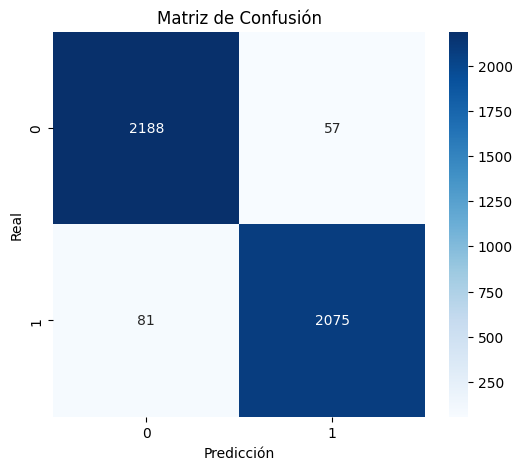

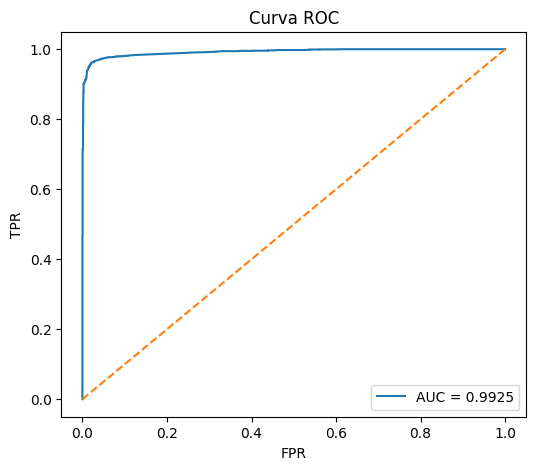

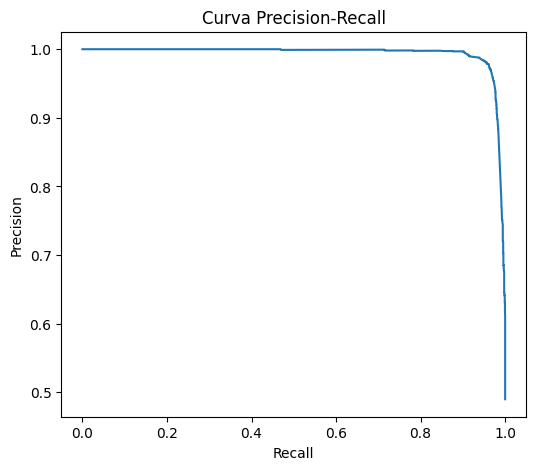

In [9]:
# --- Matriz de Confusión ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# --- ROC ---
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], "--")
plt.title("Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# --- PRECISION-RECALL ---
prec_curve, rec_curve, _ = precision_recall_curve(all_labels, all_probs)
plt.figure(figsize=(6,5))
plt.plot(rec_curve, prec_curve)
plt.title("Curva Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()
